## Librerías

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
from IPython.display import Audio
#from scipy.io import wavfile
import scipy
import soundfile as sf
#import os

## Dataset

### Leer

In [2]:
dataset = pd.read_csv("dataset.csv")

In [3]:
dataset

,Path,Instrument (in full),Instrument (abbr.),Pitch,Dynamics
0,Saxo/Sax-A5-f.wav,Saxofon_Alto,SaxA,A5,f
1,Saxo/Sax-A5-mf.wav,Saxofon_Alto,SaxA,A5,mf
2,Saxo/Sax-A5-p.wav,Saxofon_Alto,SaxA,A5,p
3,Saxo/SaxA5(2).wav,Saxofon_Alto,SaxA,A5,NaN
4,Saxo/SaxA5(3).wav,Saxofon_Alto,SaxA,A5,NaN
...,...,...,...,...,...
195,Piano/PianoA5(61).wav,Piano,Piano,A5,NaN
196,Piano/PianoA5(62).wav,Piano,Piano,A5,NaN
197,Piano/PianoA5(63).wav,Piano,Piano,A5,NaN
198,Piano/PianoA5(64).wav,Piano,Piano,A5,NaN


In [4]:
len(dataset)

200

In [5]:
# Leer el archivo con soundfile
signal, fs = sf.read(dataset.loc[1, 'Path'])
N = len(signal)
# Mostrar información
print(f"Frecuencia de muestreo: {fs} Hz")
print(f"Forma de la señal: {signal.shape}")  # Puede ser (N,) mono o (N,2) estéreo

Frecuencia de muestreo: 22050 Hz
Forma de la señal: (50341,)


### Creación tabla teórica de frecuencias

In [6]:
# Nuestra nota más grave es A2, es decir, 110 Hz
# Llegamos hasta la octava 7
frec = 55
oct = 8
lista = []
# En cada octava hay 12 notas
# Creamos una lista con las diferentes frecuencias 
for i in range(oct*12):
    lista.append(frec)
    frec = frec*2**(1/12)
# Crear tabla para visualización
# reshape(lista, (filas, columnas))
# redondeamos los valores de la lista a 2 decimales
# hay tantas filas como octavas y tantas columnas como notas(12)
tabla_frec = np.reshape(np.round(lista,2),(oct,12))
col_sist_anglo = ["A", "A#", "B", "C", "C#", "D", "D#", "E", "F", "F#", "G", "G#"]
col_sist_lat = ["La", "Sib", "Si", "Do", "Do#", "Re", "Re#", "Mi", "Fa", "Fa#", "Sol", "Sol#"]
# Creamos un dataframe con la matriz tabla_frec
df_tabla_frec = pd.DataFrame(tabla_frec, columns=[col_sist_anglo,col_sist_lat])
# Para que sea más fácil la visualización vamos a añadir una fila al principio (fila 0)
# sin valores (NaN), de esta forma A4 será 440 Hz
df_tabla_frec = pd.concat([pd.DataFrame(np.nan,index=range(1),columns=df_tabla_frec.columns),df_tabla_frec], ignore_index=True)

### Mostrar tabla

In [7]:
def mostrar_tabla():
    return df_tabla_frec[2:]

In [8]:
mostrar_tabla()

,A,A#,B,C,C#,D,D#,E,F,F#,G,G#
,La,Sib,Si,Do,Do#,Re,Re#,Mi,Fa,Fa#,Sol,Sol#
2,110.0,116.54,123.47,130.81,138.59,146.83,155.56,164.81,174.61,185.00,196.00,207.65
3,220.0,233.08,246.94,261.63,277.18,293.66,311.13,329.63,349.23,369.99,392.00,415.30
4,440.0,466.16,493.88,523.25,554.37,587.33,622.25,659.26,698.46,739.99,783.99,830.61
5,880.0,932.33,987.77,1046.50,1108.73,1174.66,1244.51,1318.51,1396.91,1479.98,1567.98,1661.22
6,1760.0,1864.66,1975.53,2093.00,2217.46,2349.32,2489.02,2637.02,2793.83,2959.96,3135.96,3322.44
7,3520.0,3729.31,3951.07,4186.01,4434.92,4698.64,4978.03,5274.04,5587.65,5919.91,6271.93,6644.88
8,7040.0,7458.62,7902.13,8372.02,8869.84,9397.27,9956.06,10548.08,11175.30,11839.82,12543.85,13289.75


## Matrices

### Crear

In [8]:
def dim_max_sennales(dataset):
    N_max = 0
    fs_comun = 22050; #44100
    for i in range(len(dataset)):
        signal, fs = sf.read(dataset.loc[i,'Path'])
        N = len(signal)
        if N>N_max:
            N_max = N
        if fs != fs_comun: # comprobación que todas las señales tienen la misma frec de muestreo
            fs_comun = np.nan
            #print(i)
    return N_max, fs_comun

In [9]:
N,fs = dim_max_sennales(dataset)

In [10]:
# hacemos la matriz de dimension 733x(N+1) para que la última columna sea
# las dimensiones temporales reales de cada señal (me hará falta en pintar())
signal_time_matrix = np.zeros((len(dataset),N+1))
signal_frec_matrix = np.zeros((len(dataset),N))


### Cargar

In [11]:
for i in range(len(dataset)):
    signal, fs = sf.read(dataset.loc[i,'Path'])
    Nn = len(signal)
    signal_time_matrix[i,:Nn] = signal
    signal_time_matrix[i,-1] = Nn
    #Colocamos la señal y en la última columna la duración real de la señal
    # el resto de la fila estará rellena de ceros
    
    #L = 2**7   # Tamaño de Ventana
    L = int(Nn * 0.01)
    # Nuestra N = 124252 que es el Tamaño de FFT

    # Calcular el espectro
    signal_frec_matrix[i,:Nn] = (1 / np.sqrt(2) * 2 / L) * np.fft.fftshift(abs(np.fft.fft(signal_time_matrix[i,:Nn])))
    #signal_frec_matrix[i,] = (1 / np.sqrt(2) * 2 / L) * np.fft.fftshift(abs(np.fft.fft(np.concatenate([signal_time_matrix[i,:Nn], np.zeros(N-L)]))))
    if i == 0:
        f1 = 440  # Frecuencia de la señal de entrada (audible)
        n = np.arange(Nn)  # Eje de tiempo discreto
        w1 = 2 * np.pi * (f1 / fs)  # Frecuencia en tiempo discreto
        signal_time_matrix[i,:Nn] = np.sqrt(2)*np.cos(w1 * n)
        # Calcular el espectro
        signal_frec_matrix[i,:Nn] = (1 / np.sqrt(2) * 2 / L) * np.fft.fftshift(abs(np.fft.fft(np.concatenate([signal_time_matrix[i,:L], np.zeros(Nn-L)]))))



In [12]:
for i in range(len(dataset)):
    signal, fs = sf.read(dataset.loc[i,'Path'])
    Nn = len(signal)
    signal_time_matrix[i,:Nn] = signal
    signal_time_matrix[i,-1] = Nn
    #Colocamos la señal y en la última columna la duración real de la señal
    # el resto de la fila estará rellena de ceros
    
    #L = 2**7   # Tamaño de Ventana
    L = int(Nn * 0.01)
    # Nuestra N = 124252 que es el Tamaño de FFT

    # Calcular el espectro
    signal_frec_matrix[i,:Nn] = (1 / np.sqrt(2) * 2 / L) * np.fft.fftshift(abs(np.fft.fft(np.concatenate([signal_time_matrix[i,:L], np.zeros(Nn-L)]))))
    #signal_frec_matrix[i,] = (1 / np.sqrt(2) * 2 / L) * np.fft.fftshift(abs(np.fft.fft(np.concatenate([signal_time_matrix[i,:Nn], np.zeros(N-L)]))))
    if i == 0:
        f1 = 440  # Frecuencia de la señal de entrada (audible)
        n = np.arange(Nn)  # Eje de tiempo discreto
        w1 = 2 * np.pi * (f1 / fs)  # Frecuencia en tiempo discreto
        signal_time_matrix[i,:Nn] = np.sqrt(2)*np.cos(w1 * n)
        # Calcular el espectro
        signal_frec_matrix[i,:Nn] = (1 / np.sqrt(2) * 2 / L) * np.fft.fftshift(abs(np.fft.fft(np.concatenate([signal_time_matrix[i,:L], np.zeros(Nn-L)]))))


## Funciones

### Escuchar

In [20]:
def escuchar(i):
    display(Audio(dataset.loc[i,'Path'],autoplay = True))
    return

### Encontrar nota

In [22]:
def encontrar_nota(nota):
    filas = dataset[dataset['Pitch']==nota].index.tolist()
    return filas

### Encontrar instrumento

In [23]:
def encontrar_instrumento(instr):
    filas = dataset[dataset['Instrument (in full)']==instr].index.tolist()
    return filas

### Detectar m máximos

In [29]:
# decido cuantos máximos se van a tener en cuenta
num_maximos = 10

In [779]:
TolR = 500
TolL = 500

In [791]:
def detectar_maximos(i,m,a):
    cont = 0
    señal = 0
    señal = np.copy(signal_frec_matrix_norm[i]) # sin esta función me da problemas de referencias compartidas
    lista = []
    lista_max = []
    lista_frec = []
    N = int(signal_time_matrix[i,-1])
    # Crear el eje de frecuencias
    frec = fs*(np.arange(N)/N - 0.5)#np.linspace(0,0.5,int(N/2))
    while cont<m:
        loc_maximo = np.argmax(señal)
        indices_a_quitar = list(range(loc_maximo - TolL, loc_maximo + TolR + 1))
        #señal = np.delete(señal,indices_a_quitar)
        señal[indices_a_quitar] = 0
        cont += 1
        lista_max.append(loc_maximo)
        lista_frec.append(frec[loc_maximo])
    if a==0: 
        lista_max.sort() # ordenar la lista
        lista = np.copy(lista_max)
    else : 
        lista_frec.sort() 
        lista = np.copy(lista_frec)
    # si a != 0 entonces devuelve la lista con las frecuencias
    # si a = 0 se devuelve la lista con la posición donde se encuentran los máximos en el array
    return lista

## Matrices normalizadas

### Crear

In [ ]:
# hacemos la matriz de dimension 200x(N+1) para que la última columna sea
# las dimensiones temporales reales de cada señal (me hará falta en pintar())
signal_time_matrix_norm = np.zeros((len(dataset),N+1))
signal_frec_matrix_norm = np.zeros((len(dataset),N))

### Cargar matriz de tiempo normalizada

In [14]:
for i in range(len(dataset)): # normalizada std sqrt(mean)
    Nn = int(signal_time_matrix[i,-1])  # longitud de la señal i
    rms = np.sqrt(np.mean(signal_time_matrix[i,:Nn]**2))
    # rms = sqrt(potencia)
    
    # Normalizar por la potencia RMS
    signal_time_matrix_norm[i,:Nn] = signal_time_matrix[i,:Nn] / rms  # se hace la 
    signal_time_matrix_norm[i,-1] = Nn
    vector_x_rms[i] = rms
    if abs(np.mean(signal_time_matrix_norm[i,:Nn]**2)-1)>1e-10:
        print("Error, la potencia normalizada no es 1 en la señal ",i)

In [ ]:
for i in range(len(dataset)):
    if abs(vector_x_rms[i]-1) < 1e-1:
        print(i)
    # NO VALE PARA NADA

0


### Cargar matriz de frecuencia normalizada

In [16]:
# normalizamos por el máximo
for i in range(len(dataset)):
    max = np.max(signal_frec_matrix[i,:])
    signal_frec_matrix_norm[i,:] = signal_frec_matrix[i,:]/max

In [ ]:
# normalizamos por aportación de cada máximo tenido en cuenta
#for i in range(len(dataset)):
#    lista_pos_max = detectar_maximos(i,num_maximos,0).tolist()
#    lista_max = [signal_frec_matrix[i][l] for l in lista_pos_max]
#    maximos_2 = [x**2 for x in lista_max]
#    rms = np.sqrt(sum(maximos_2))
#    signal_frec_matrix_norm[i,:] = signal_frec_matrix[i,:] / rms  # se hace la 

## Detectar maximos

In [17]:
# decido cuantos máximos se van a tener en cuenta
num_maximos = 10

In [18]:
TolR = 500
TolL = 500

In [19]:
def detectar_maximos(i,m,a):
    cont = 0
    señal = 0
    señal = np.copy(signal_frec_matrix_norm[i]) # sin esta función me da problemas de referencias compartidas
    lista = []
    lista_max = []
    lista_frec = []
    N = int(signal_time_matrix[i,-1])
    # Crear el eje de frecuencias
    frec = fs*(np.arange(N)/N - 0.5)#np.linspace(0,0.5,int(N/2))
    if a != 0 : m= 2*m
    while cont<m:
        loc_maximo = np.argmax(señal[:N])
        indices_a_quitar = list(range(loc_maximo - TolL, loc_maximo + TolR + 1))
        #señal = np.delete(señal,indices_a_quitar)
        señal[indices_a_quitar] = 0
        cont += 1
        lista_max.append(loc_maximo)
        lista_frec.append(frec[loc_maximo])
    if a==0: 
        lista_max.sort() # ordenar la lista
        lista = np.copy(lista_max)
    else : 
        lista_frec.sort() 
        lista = np.copy(lista_frec)
        lista = [x for x in lista if x > 0]
    # si a != 0 entonces devuelve la lista con las frecuencias
    # si a = 0 se devuelve la lista con la posición donde se encuentran los máximos en el array
    return lista

## Función pintar

In [20]:
def pintar(i):

    N = int(signal_time_matrix[i,-1])
    
    # Crear el eje de tiempo
    time = np.linspace(0, N/fs, N)
    
    # Crear el eje de frecuencias
    #frec = np.linspace(0,0.5,int(N/2)) # f'c[-0.5,0.5]
    frec = np.arange(N)/N -0.5  # Eje de frecuencias 
    # Crear figura con cuadricula 2x2
    fig, ax = plt.subplots(2,2,figsize=(15,6))
    


    # Graficar la señal de audio
    ax[0,0].plot(time, signal_time_matrix[i,:N]) # el tiempo se ajusta a cada señal entonces solo mostramos la señal que esta en la matriz, no los ceros
    ax[0,0].set(xlabel="Tiempo (s)",ylabel="Amplitud")
    ax[0,0].set_title("Forma de onda del audio (No Zoom)")

    ax[1,0].plot(time[int(N/2-1000):int(N/2+1000)], signal_time_matrix[i,:N][int(N/2-1000):int(N/2+1000)])
    ax[1,0].set(xlabel="Tiempo (s)",ylabel="Amplitud")
    ax[1,0].set_title("Forma de onda del audio (Zoom)")

    ax[0,1].plot(fs*frec, signal_frec_matrix[i,:int(N)])
    #ax[0,1].plot(fs*frec, signal_frec_matrix[i,:int(N/2)])
    ax[0,1].axis([0, fs/7,0,None])  # Configurar límites de ejes
    ax[0,1].set(xlabel="Frecuencia (Hz)")
    ax[0,1].set_title("Forma de onda del audio (No Zoom)")
    
    #ax[1,1].plot(fs*frec, 20*np.log10(signal_frec_matrix[i,:int(N/2)]))
    ax[1,1].plot(fs*frec, 20*np.log10(signal_frec_matrix[i,:int(N)]))
    ax[1,1].axis([0, fs/7, -70, 10])  # Configurar límites de ejes
    ax[1,1].set(xlabel="Frecuencia (Hz)")
    ax[1,1].set_title("Forma de onda del audio (Zoom)")
    
    frecuencia_tabla = df_tabla_frec.loc[int(dataset.loc[i,'Pitch'][-1]),dataset.loc[i,'Pitch'][:-1]]
    ax[1,1].set_xticks(np.append(plt.xticks()[0],frecuencia_tabla))

    fig.tight_layout()
    plt.show()
    print(f"La nota escuchada es {dataset.loc[i,'Pitch']} tocada por un {dataset.iloc[i,1]}.\nSegún la tabla de frecuencias {frecuencia_tabla}")

    return 

## Función pintar normalizado

In [21]:
def pintar_norm(i):
    
    N = int(signal_time_matrix[i,-1])

    #Crear el eje de tiempos
    time = np.linspace(0,N/fs,N)

    # Crear el eje de frecuencias
    #frec = fs*np.linspace(0,0.5,N) # f'c[-0.5,0.5]
    frec = np.arange(N) / N - 0.5  # Eje de frecuencias normalizado
    
    # Crear figura con cuadricula 2x2
    fig, ax = plt.subplots(2,2,figsize=(15,6))

    # Graficar la señal de audio
    ax[0,0].plot(time, signal_time_matrix_norm[i,:N]) # el tiempo se ajusta a cada señal entonces solo mostramos la señal que esta en la matriz, no los ceros
    ax[0,0].set(xlabel="Tiempo (s)",ylabel="Amplitud")
    ax[0,0].set_title("Forma de onda del audio (No Zoom)")

    ax[1,0].plot(time[int(N/2-1000):int(N/2+1000)], signal_time_matrix_norm[i,:N][int(N/2-1000):int(N/2+1000)])
    ax[1,0].set(xlabel="Tiempo (s)",ylabel="Amplitud")
    ax[1,0].set_title("Forma de onda del audio (Zoom)")


    ax[0,1].plot(frec*fs, signal_frec_matrix_norm[i,:N])
    ax[0,1].set_xlim(0,fs/7)
    ax[0,1].set_ylim(int(np.min(signal_frec_matrix_norm[i,:N])),int(np.max(signal_frec_matrix_norm[i,:N])))
    ax[0,1].set(xlabel="Frecuencia (Hz)")
    ax[0,1].set_title("Espectro (V)")
        
    ax[1,1].plot(fs*frec, 20*np.log10(signal_frec_matrix_norm[i,:N]))
    ax[1,1].axis([0, fs/7, -9, 0])  # Configurar límites de ejes
    ax[1,1].set_xlim(0,fs/7)
    ax[1,1].set_ylim(-70,int(20*np.log10(np.max(signal_frec_matrix_norm[i,:N]))))# HAGO EL MAXIMO DE LA SEÑAL PORQUE NO SE PUEDE HACER MAX DE -INF
    ax[1,1].set(xlabel="Frecuencia (Hz)")
    ax[1,1].set_title("Espectro (dB)")
        
    frecuencia_tabla = df_tabla_frec.loc[int(dataset.loc[i,'Pitch'][-1]),dataset.loc[i,'Pitch'][:-1]]
    ax[1,1].set_xticks(np.append(plt.xticks()[0],frecuencia_tabla))

    fig.tight_layout()
    plt.show()
    #print(f"La nota escuchada es {dataset.loc[i,'Pitch']} tocada por un {dataset.iloc[i,1]}.\nSegún la tabla de frecuencias {frecuencia_tabla}")


## Pruebas

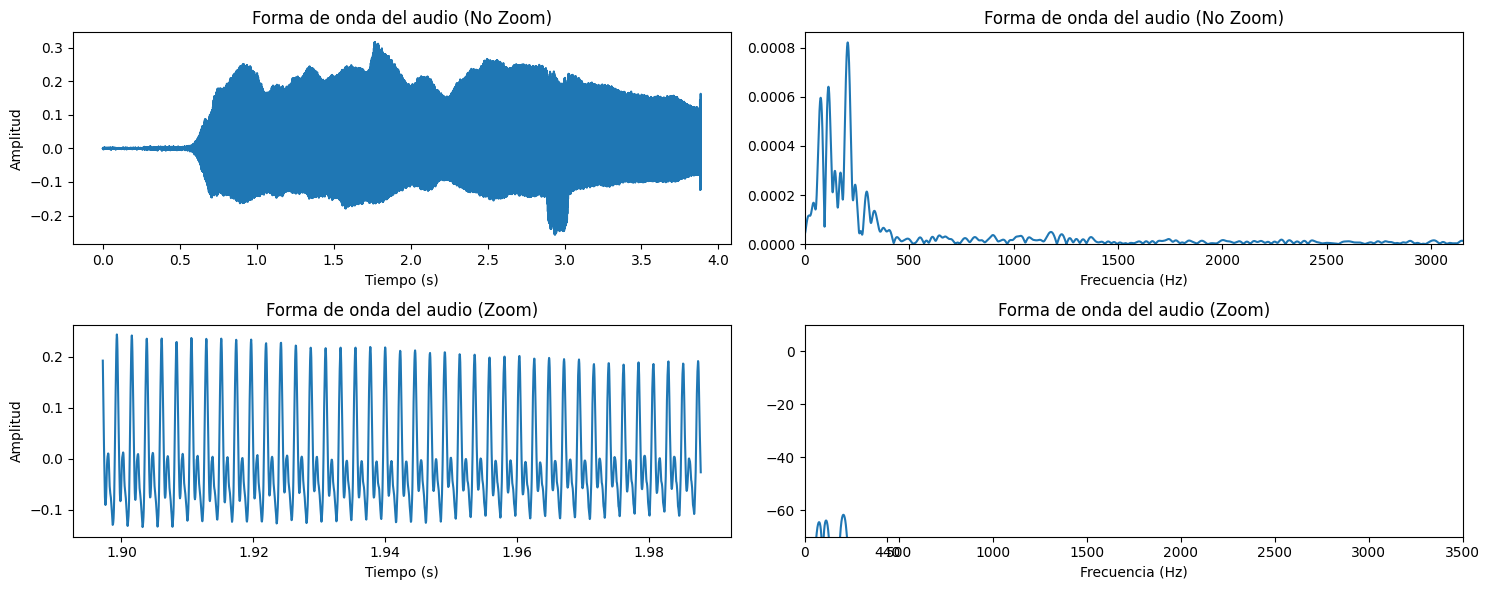

La nota escuchada es A4 tocada por un Saxofon_Alto.
Según la tabla de frecuencias La    440.0
Name: 4, dtype: float64


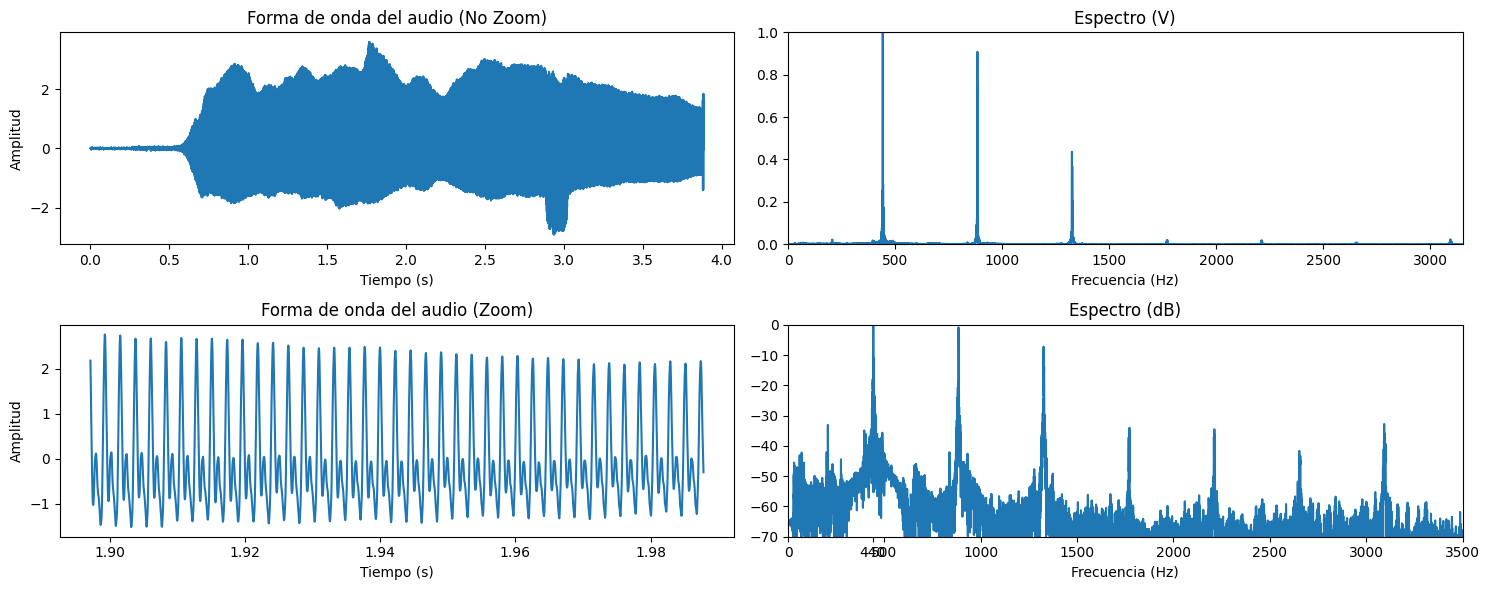

In [709]:
i=8
pintar(i)
pintar_norm(i)

(834.0, 934.0)

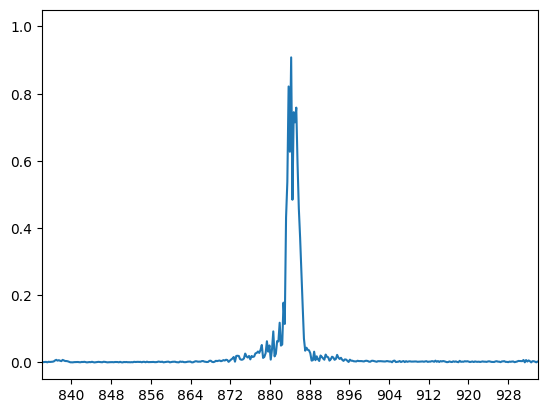

In [700]:
import matplotlib.ticker as ticker
i= 8
N = int(signal_time_matrix[i,-1])

#Crear el eje de tiempos
time = np.linspace(0,N/fs,N)

# Crear el eje de frecuencias
#frec = fs*np.linspace(0,0.5,N) # f'c[-0.5,0.5]
frec = np.arange(N) / N - 0.5  # Eje de frecuencias normalizado
fig, ax = plt.subplots()
ax.plot(frec*fs, signal_frec_matrix_norm[i,:N])

# Agregar más marcas en el eje X automáticamente
ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=13))  # Hasta 15 marcas

# Mostrar solo el eje X positivo
ax.set_xlim((884-50), (884+50))


## Otro

In [304]:
lista = [3, 4, 3, 7, 9, 2, 8, 3]
np.argmax(lista)

np.int64(4)

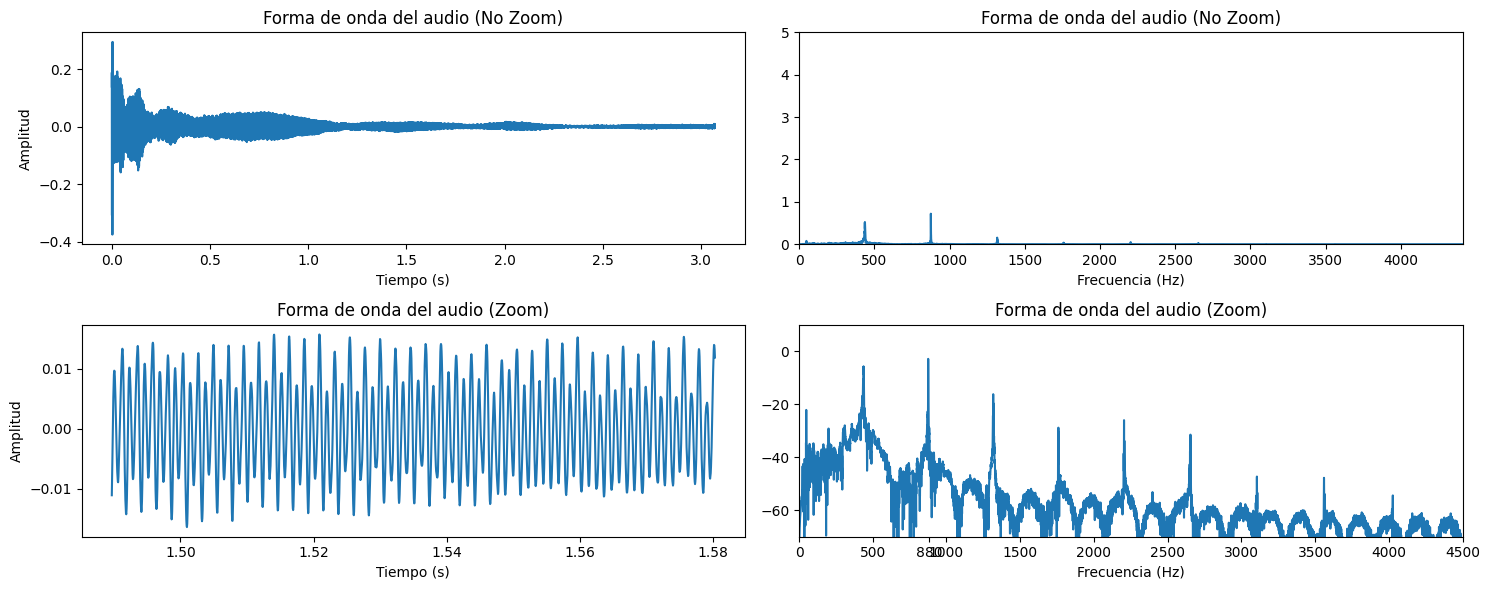

La nota escuchada es A5 tocada por un Piano.
Según la tabla de frecuencias La    880.0
Name: 5, dtype: float64


TypeError: 'numpy.float64' object is not callable

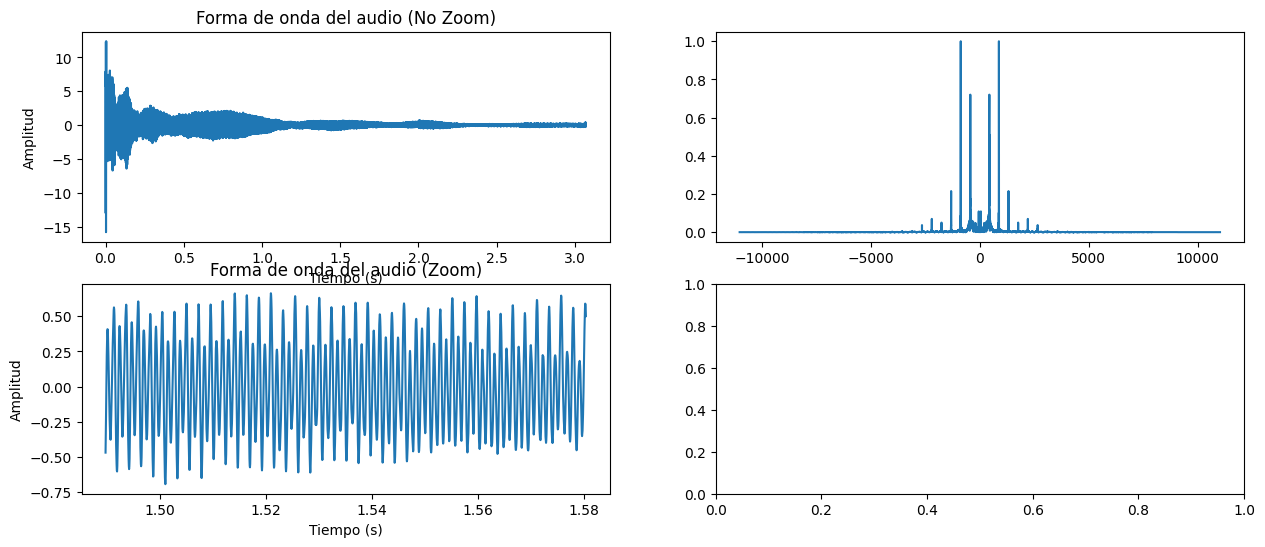

In [342]:
i= 190
pintar(i)
pintar_norm(i)

In [ ]:
# normalizamos por aportación de cada máximo tenido en cuenta
#for i in range(len(dataset)):
#    lista_pos_max = detectar_maximos(i,num_maximos,0).tolist()
#    lista_max = [signal_frec_matrix[i][l] for l in lista_pos_max]
#    maximos_2 = [x**2 for x in lista_max]
#    rms = np.sqrt(sum(maximos_2))
#    signal_frec_matrix_norm[i,:] = signal_frec_matrix[i,:] / rms  # se hace la 

In [320]:
i=0
np.max(20*np.log10(signal_frec_matrix_norm[i][:]))
np.max(signal_time_matrix_norm[i][:-1])
np.max(20*np.log10(signal_frec_matrix[i][:]))

np.float64(-2.9988647174786487)

## Sacar el vector alfa

In [271]:
def sacar_alfa(i):
    alfa = np.zeros(num_maximos).tolist()
    lista_pos_max = detectar_maximos(i,num_maximos,0).tolist()
    lista_max = [signal_frec_matrix_norm[i][l] for l in lista_pos_max]
    maximos_2 = [x**2 for x in lista_max]
    alfa = maximos_2
    return alfa
    # vector que se le meterá al clasificador

In [273]:
sum(sacar_alfa(135))

0.9999999999999998

## Preprocesado señal

In [22]:
rms = np.zeros((len(dataset),num_maximos))

In [23]:
def separar_sennal(i,num_maximos):
    
    N = signal_time_matrix[i,-1]
    print(N)
    tol = 25*N/fs
    dim_trozos_sennal = int(2*tol)
    signal = np.zeros((num_maximos,dim_trozos_sennal))
    
    for l in range(num_maximos):
        #signal[l] = np.zeros((dim_trozos_sennal))

        frecuencia = 221*(2*(l+1))*N/(fs)
        frecuencia = detectar_maximos(i,num_maximos,1)[l]*N/fs
        #frecuencia = detectar_maximos(i,num_maximos,0)[l]
        print(detectar_maximos(i,num_maximos,1)[l])
        f_min = int(0.5*N+frecuencia-tol)  # Frec mínimo (Hz)
        f_max = int(0.5*N+frecuencia+tol)  # Frec máximo (Hz)

       
        plt.plot(20*np.log10(signal_frec_matrix[i,f_min:f_max]))
        #plt.plot((signal_frec_matrix_norm[i,f_min:f_max]))
        #plt.show()
        #rms[i,l] = np.sqrt(np.mean(signal_frec_matrix_norm[i,f_min:f_max]**2))
        #signal[l,:] = 20*np.log10(signal_frec_matrix[i,int((0.5*N+frecuencia-tol)):int((0.5*N+frecuencia+tol))])


In [42]:
num_maximos = 16
TolR = 50
TolL = 50

In [ ]:
vector_x_rms = np.zeros(len(dataset),num_maximos)

In [ ]:
def obtener_vector_alfa(i,num_maximos):
    vector_alfa = np.zeros(num_maximos)
    N = int(signal_time_matrix[i,-1])
    rms = np.zeros(num_maximos)
    rms_total=sum(signal_frec_matrix_norm[i,int(Nn/2):]**2)/N
    for l in np.arange(num_maximos):
        frec_hz = 221*2*(l+1)
        if frec_hz>fs/2: frec_hz = fs/2- TolR
        frecuencia = int((((frec_hz*0.5)/(fs/2))+0.5)*N)
        #print(frec_hz)
        f_min = frecuencia - TolL
        f_max = frecuencia + TolR
        #plt.plot(20*np.log10(signal_frec_matrix_norm[i,f_min:f_max]))
        #plt.show()
        #print(f"Frec_max=",f_max,"  Frec_min=",f_min)
        #rms[l] = np.sqrt(np.abs(np.mean((signal_frec_matrix_norm[i,f_min:f_max]**2))))
        #rms[l] = np.abs(np.mean((signal_frec_matrix_norm[i,f_min:f_max]**2)))
        rms[l] = sum(signal_frec_matrix_norm[i,f_min:f_max]**2)/N
        vector_alfa[l] = rms[l]/rms_total
        #print(f"Rms normalizado de ",l,": ",vector_x_rms[l])
    return vector_alfa


NameError: name 'df_tabla_frec' is not defined

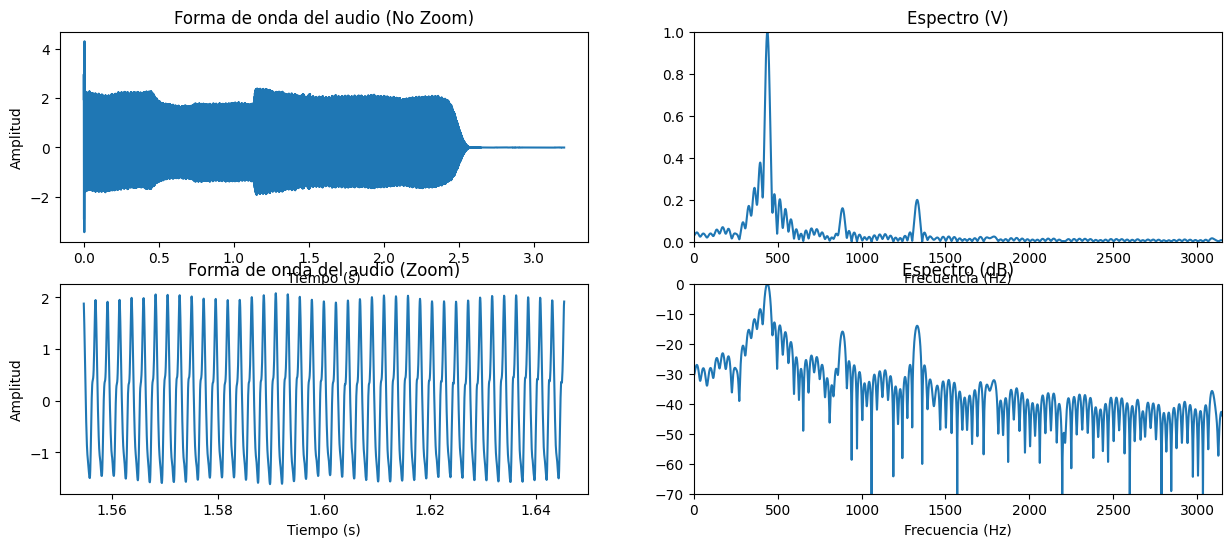

In [87]:
pintar_norm(70)

Frec_max= 36744   Frec_min= 36644
Rms normalizado de  0 :  0.9148796572364299
Frec_max= 38158   Frec_min= 38058
Rms normalizado de  1 :  0.020936035098907294
Frec_max= 39573   Frec_min= 39473
Rms normalizado de  2 :  0.052153190333526535
Frec_max= 40987   Frec_min= 40887
Rms normalizado de  3 :  0.004165115673263902
Frec_max= 42402   Frec_min= 42302
Rms normalizado de  4 :  6.360161687953971e-05
Frec_max= 43816   Frec_min= 43716
Rms normalizado de  5 :  6.684182154668662e-05
Frec_max= 45230   Frec_min= 45130
Rms normalizado de  6 :  4.63613390554602e-05
Frec_max= 46645   Frec_min= 46545
Rms normalizado de  7 :  6.91713545437523e-05
Frec_max= 48059   Frec_min= 47959
Rms normalizado de  8 :  1.0873497646592142e-05
Frec_max= 49474   Frec_min= 49374
Rms normalizado de  9 :  3.8417564817125935e-07
Frec_max= 50888   Frec_min= 50788
Rms normalizado de  10 :  1.9629314509447583e-06
Frec_max= 52302   Frec_min= 52202
Rms normalizado de  11 :  4.753429142176686e-07
Frec_max= 53717   Frec_min= 536

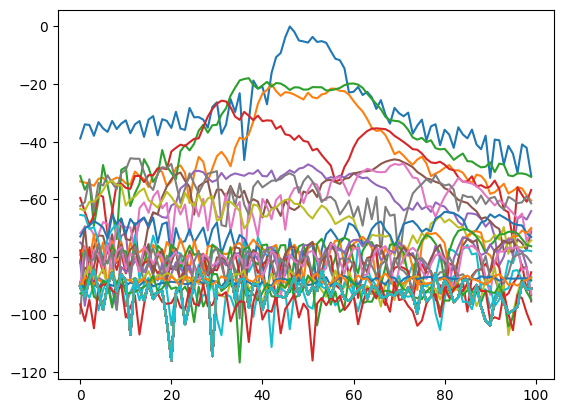

In [1004]:
i = 70
rms = separar_señal_maximos(i,90)
#print(rms)
print("Suma rms: ",sum(rms))
Nn = int(signal_time_matrix[i,-1])
#print((np.mean(signal_frec_matrix_norm[i,:Nn]**2)))
print((sum(signal_frec_matrix_norm[i,int(Nn/2):]**2))/Nn)
#print(np.sqrt(np.mean(signal_frec_matrix_norm[i]**2)))
#print(np.sqrt(np.mean(abs(signal_frec_matrix_norm[i]**2))))


In [894]:
i = 8
señal = np.copy(signal_frec_matrix_norm[i]) 
loc_maximo = np.argmax(señal)
print(loc_maximo)
print((((442*0.5)/(fs/2))+0.5)*signal_time_matrix[i,-1])

41114
44549.68503401361


76514.0
441.49567399430146
882.4149828789506
1331.1152207439154
1764.8299657579012


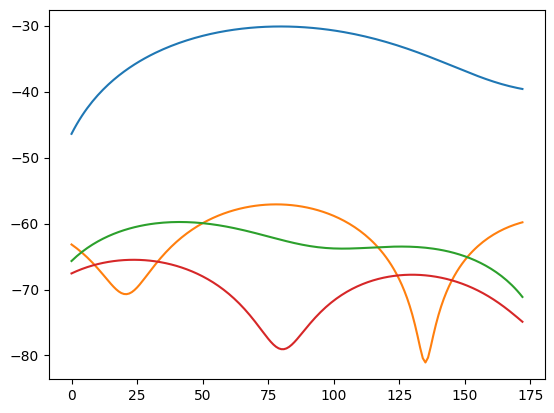

In [836]:
separar_sennal(i = 100,num_maximos = 4)

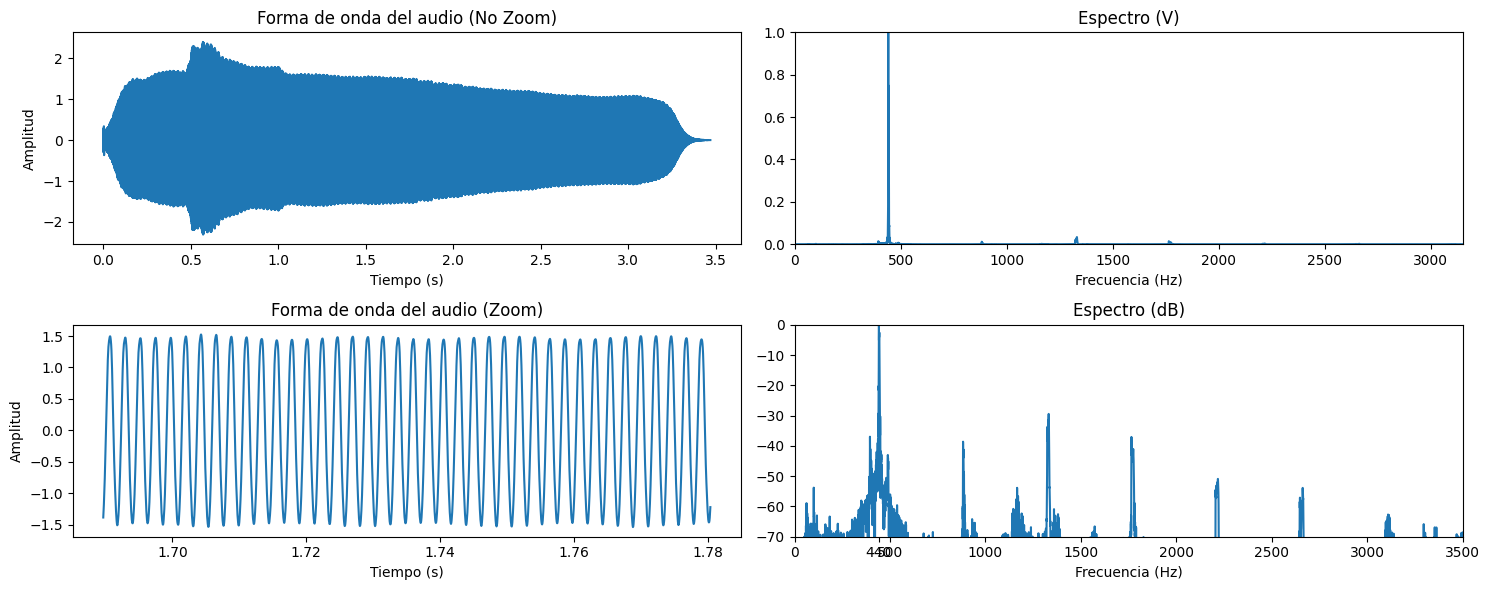

In [835]:
pintar_norm(100)

In [547]:
print(signal_time_matrix[5,-1])
for i in range(int(signal_time_matrix[5,-1])):
    
    if (20*np.log10(signal_frec_matrix_norm[5,i])==0):
        print(i)

74639.0
38810
